In [2]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,926 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155047 files and d

In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', my_path)
sys.path.insert(0,my_path)

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [14]:
# 필요한 데이터셋 불러오기
purprd = pd.read_csv('/content/drive/MyDrive/lmembers/03 추가데이터_통계자료, 파생자료 등/dataset/purprd.csv')
df = pd.read_csv('/content/drive/MyDrive/lmembers/03 추가데이터_통계자료, 파생자료 등/dataset/신규_기존.csv')

In [6]:
# 분석 대상 품목별 구매금액 데이터 프레임 생성하기
purprd14_1 = purprd[purprd['period'] == '2014_1'] # 1기(2014년 상반기 구매데이터)
purprd15_2 = purprd[purprd['period'] == '2015_2'] # 4기(2015년 하반기 구매데이터)

In [15]:
# 각 시점에 구매액이 있으면 기존 고객으로 분류
def cust(x1, x2, x3, x4):
    if (x1 == '기존')&(x2 == '기존')&(x3 == '기존')&(x4 == '기존'):
        return '기존'
    else:
        return '신규'
        
df['cust'] = df.apply(lambda x : cust(x['2014_1_신규'],x['2014_2_신규'],x['2015_1_신규'],x['2015_2_이탈']),axis=1)

# 기존고객만 분류한 데이터프레임 df 지정, 2014년 상반기, 2015년 하반기 매출액 컬럼만 추출
df = df[df['cust'] == '기존']
df = df[['cust_no', '2014_1', '2015_2']]

# 분석 대상 target : 2015년 하반기, 2014년 상반기 구매금액 차이
# status : 구매금액 증감 여부 
df['target'] = df['2015_2'] - df['2014_1']

# 구매 증감 사용자 함수
def status(x):
  if x > 0 : return '증가'
  elif x == 0 : return '유지'
  else: return '감소'

# 구매 증감 여부 컬럼 생성
df['status'] = df['target'].apply(status)

# 필요한 컬럼만 추출
df = df[['cust_no', '2014_1', '2015_2', 'status']]
df

,cust_no,2014_1,2015_2,status
0,1,19925355.0,13102518.0,감소
1,2,24323230.0,25843820.0,증가
2,3,851215.0,679118.0,감소
3,4,5042106.0,3737257.0,감소
4,5,5460150.0,2616260.0,감소
...,...,...,...,...
19355,19356,170160.0,2434587.0,증가
19356,19357,91950.0,2246675.0,증가
19358,19359,43190.0,1092380.0,증가
19359,19360,368050.0,886060.0,증가


In [16]:
# 구매 빈도 구하는 사용자 함수
def freq(purprd):
  # 구매 횟수
  freq = pd.pivot_table(purprd, index = 'cust_no', values = 'receipt_no', aggfunc = 'count')
  freq.columns = ['freq']
  freq.reset_index(inplace = True)
  return freq

# 두 기간의 구매빈도 데이터프레임 결함
a = freq(purprd14_1)
b = freq(purprd15_2)
c = pd.merge(a, b, on='cust_no',how='outer',suffixes=['_1','_4'])

# 매출 증감 데이터셋과 결합
df = pd.merge(df, c, on = 'cust_no', how = 'left')
df

,cust_no,2014_1,2015_2,status,freq_1,freq_4
0,1,19925355.0,13102518.0,감소,238.0,151.0
1,2,24323230.0,25843820.0,증가,339.0,245.0
2,3,851215.0,679118.0,감소,348.0,232.0
3,4,5042106.0,3737257.0,감소,270.0,225.0
4,5,5460150.0,2616260.0,감소,377.0,89.0
...,...,...,...,...,...,...
19142,19356,170160.0,2434587.0,증가,47.0,416.0
19143,19357,91950.0,2246675.0,증가,12.0,342.0
19144,19359,43190.0,1092380.0,증가,17.0,369.0
19145,19360,368050.0,886060.0,증가,41.0,80.0


In [17]:
# 로그 차분(구매 금액 증감율, 구매 빈도 증감율 계산)
# 금액이 커지면 오차가 크다는 단점이 있지만, 분포의 형태가 정규분포의 형태를 띄므로 분석에 용이
df['sales_log_rate'] = np.log(df['2015_2']) - np.log(df['2014_1'])
df['freq_log_rate'] = np.log(df['freq_4']) - np.log(df['freq_1'])
df

,cust_no,2014_1,2015_2,status,freq_1,freq_4,sales_log_rate,freq_log_rate
0,1,19925355.0,13102518.0,감소,238.0,151.0,-0.419189,-0.454991
1,2,24323230.0,25843820.0,증가,339.0,245.0,0.060640,-0.324742
2,3,851215.0,679118.0,감소,348.0,232.0,-0.225870,-0.405465
3,4,5042106.0,3737257.0,감소,270.0,225.0,-0.299472,-0.182322
4,5,5460150.0,2616260.0,감소,377.0,89.0,-0.735730,-1.443609
...,...,...,...,...,...,...,...,...
19142,19356,170160.0,2434587.0,증가,47.0,416.0,2.660793,2.180538
19143,19357,91950.0,2246675.0,증가,12.0,342.0,3.195962,3.349904
19144,19359,43190.0,1092380.0,증가,17.0,369.0,3.230505,3.077583
19145,19360,368050.0,886060.0,증가,41.0,80.0,0.878566,0.668455


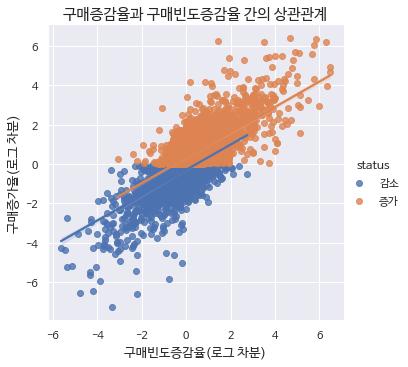

In [10]:
# 구매증감율과 구매빈도증감율과의 상관관계 
plt.rc('font', family = 'NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
sns.lmplot(data = df, x = 'freq_log_rate', y = 'sales_log_rate', hue = 'status', height = 5)
plt.ylabel('구매증가율(로그 차분)', fontsize = 13)
plt.xlabel('구매빈도증감율(로그 차분)', fontsize = 13)
plt.title('구매증감율과 구매빈도증감율 간의 상관관계', fontsize = 15)
plt.show()

In [18]:
def n_item(purprd):
  # 최대 구매 품목
  item = pd.pivot_table(purprd, index = 'cust_no', columns = 'cat_dae', values = 'pur_amount', aggfunc = 'sum')
  columns = item.columns.tolist()
  # 구매품목 수
  item['num_item'] = item[columns].apply(lambda x : x.notna().sum(), axis = 1)
  item.reset_index(inplace = True)
  return item[['cust_no', 'num_item']]

# 두 기간의 구매품목 수 데이터프레임 결함
a = n_item(purprd14_1)
b = n_item(purprd15_2)
c = pd.merge(a, b, on='cust_no',how='outer',suffixes=['_1','_4'])

# 매출 증감 데이터셋과 결합
df = pd.merge(df, c, on = 'cust_no', how = 'left')

In [20]:
# 구매품목 수 변화
df['num_item_ch'] = df['num_item_4'] - df['num_item_1']
df

,cust_no,2014_1,2015_2,status,freq_1,freq_4,sales_log_rate,freq_log_rate,num_item_1,num_item_4,num_item_ch
0,1,19925355.0,13102518.0,감소,238.0,151.0,-0.419189,-0.454991,8.0,9.0,1.0
1,2,24323230.0,25843820.0,증가,339.0,245.0,0.060640,-0.324742,9.0,9.0,0.0
2,3,851215.0,679118.0,감소,348.0,232.0,-0.225870,-0.405465,4.0,4.0,0.0
3,4,5042106.0,3737257.0,감소,270.0,225.0,-0.299472,-0.182322,9.0,9.0,0.0
4,5,5460150.0,2616260.0,감소,377.0,89.0,-0.735730,-1.443609,9.0,6.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...
19142,19356,170160.0,2434587.0,증가,47.0,416.0,2.660793,2.180538,3.0,8.0,5.0
19143,19357,91950.0,2246675.0,증가,12.0,342.0,3.195962,3.349904,3.0,9.0,6.0
19144,19359,43190.0,1092380.0,증가,17.0,369.0,3.230505,3.077583,3.0,4.0,1.0
19145,19360,368050.0,886060.0,증가,41.0,80.0,0.878566,0.668455,3.0,6.0,3.0


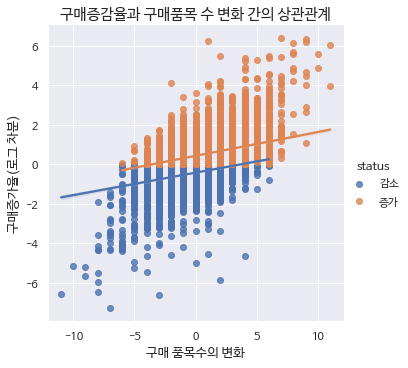

In [21]:
# 구매증감율과 구매품목 수와의 상관관계 
plt.rc('font', family = 'NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
sns.lmplot(data = df, x = 'num_item_ch', y = 'sales_log_rate', hue = 'status', height = 5)
plt.ylabel('구매증가율(로그 차분)', fontsize = 13)
plt.xlabel('구매 품목수의 변화', fontsize = 13)
plt.title('구매증감율과 구매품목 수 변화 간의 상관관계', fontsize = 15)
plt.show()

In [22]:
# 내구재, 준내구재, 비내구재, 기타서비스 분류
def durables(x):
  if x in ['가공식품', '교육/문화용품', '신선식품', '의약품']: return '비내구재'
  elif x in ['의류', '일상용품', '전문스포츠/레저', '패션잡화']: return '준내구재'
  elif x in ['가구/인테리어', '가전', '명품']: return '내구재'
  else: return '기타'
purprd['durables'] = purprd['cat_dae'].apply(durables)

In [26]:
# 구매내역 데이터셋에 해당 고객이 구매감소 고객인지 구매증가 고객인지 구분
purprd_di = pd.merge(df[['cust_no', 'status']], purprd, on = 'cust_no', how = 'right')
purprd_di

,cust_no,status,channel,receipt_no,code_dae,code_jung,code_so,branch_no,pur_date,pur_hour,pur_amount,cat_dae,cat_jung,cat_so,year,month,yoil,half,week,pur_time,period,pur_week_time,quarter,y_quarter,y_month,durables
0,17218,증가,B,8664000,15,1504,B150401,44,2014-02-22,20,2420,가공식품,탄산음료,사이다,2014,2,토,1,주말,밤,2014_1,주말_밤,1,2014_1,2014_02,비내구재
1,17218,증가,B,8747265,15,1504,B150401,44,2015-06-27,10,970,가공식품,탄산음료,사이다,2015,6,토,1,주말,오전,2015_1,주말_오전,2,2015_2,2015_06,비내구재
2,17218,증가,B,8720725,15,1504,B150401,44,2015-01-29,17,1280,가공식품,탄산음료,사이다,2015,1,목,1,주중,오후,2015_1,주중_오후,1,2015_1,2015_01,비내구재
3,17218,증가,B,8725005,15,1504,B150401,44,2015-02-24,18,1380,가공식품,탄산음료,사이다,2015,2,화,1,주중,오후,2015_1,주중_오후,1,2015_1,2015_02,비내구재
4,17218,증가,B,8748478,15,1504,B150401,44,2015-07-04,15,980,가공식품,탄산음료,사이다,2015,7,토,2,주말,오후,2015_2,주말_오후,3,2015_3,2015_07,비내구재
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28593025,18799,NaN,D,229558,2,204,D020406,24,2015-05-08,13,3000,일상용품,구강케어,치약/칫솔세트,2015,5,금,1,주중,오후,2015_1,주중_오후,2,2015_2,2015_05,준내구재
28593026,18799,NaN,C,11082648,13,1305,C130502,358,2015-10-30,19,7800,가공식품,차류,녹차/홍차,2015,10,금,2,주중,밤,2015_2,주중_밤,4,2015_4,2015_10,비내구재
28593027,18799,NaN,D,227041,4,402,D040218,22,2015-09-15,15,3900,가공식품,음료,식수용차,2015,9,화,2,주중,오후,2015_2,주중_오후,3,2015_3,2015_09,비내구재
28593028,18799,NaN,C,11082648,13,1306,C130603,358,2015-10-30,19,3300,가공식품,건강식품,건강보조식품세트,2015,10,금,2,주중,밤,2015_2,주중_밤,4,2015_4,2015_10,비내구재


In [27]:
sns.set_theme(style = 'ticks')

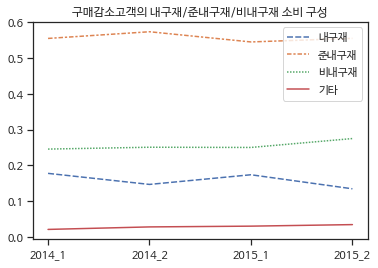

In [29]:
# 구매 감소 고객의 내구재/준내구재/비내구재 구매 비중
durables_share1 = pd.pivot_table(purprd_di[purprd_di['status'] == '감소'], index = 'durables', columns = 'period', values = 'pur_amount', aggfunc = 'sum', fill_value = 0)
durables_share1/durables_share1.sum()
plt.rc('font', family = 'NanumBarunGothic')
sns.lineplot(data = (durables_share1/durables_share1.sum()).T, hue_order = ['내구재','준내구재', '비내구재', '기타'])
plt.title('구매감소고객의 내구재/준내구재/비내구재 소비 구성')
plt.xlabel(None)
plt.legend(loc = 1)
plt.show()

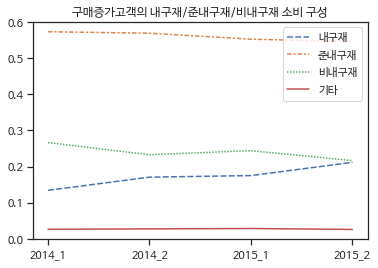

In [30]:
# 구매 감소 고객의 내구재/준내구재/비내구재 구매 비중
durables_share2 = pd.pivot_table(purprd_di[purprd_di['status'] == '증가'], index = 'durables', columns = 'period', values = 'pur_amount', aggfunc = 'sum', fill_value = 0)
durables_share2/durables_share2.sum()
plt.rc('font', family = 'NanumBarunGothic')
sns.lineplot(data = (durables_share2/durables_share2.sum()).T, hue_order = ['내구재','준내구재', '비내구재', '기타'])
plt.title('구매증가고객의 내구재/준내구재/비내구재 소비 구성')
plt.xlabel(None)
plt.legend(loc = 1)
plt.show()